## A decision support system for Risk assessment
Model Selection - I am going to compare the best feature based on eye movements for predicting risk assesment. 

The data are from 32 subjects who watched 20 driving clips. Each row identifies a period of 1 second within trials. Subjects identified with a button press those moments where they thought the car should brake. Data include evenly windows before and indepedent from subject's report.

Variables included are:

1) A Risk status: positive or negative.

2) Demographic variables: age, race, gender.

3) Eye movement variables: Saccadic magnitude, number of fixations, fixation duration, dispersion in x, dispersion in y, number of blinks, pupil size

Below I'll test six best pairs of features.

In [64]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import operator
import statsmodels.api as sm
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from sklearn.metrics import accuracy_score

from tensorflow.keras import layers
#import warnings
#warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline

In [49]:
# read the data, create at copy
df0 = pd.read_excel('/Users/FranciscoCostela/Desktop/Risk/riskForPython.xls')
df1 = pd.DataFrame.copy(df0)

#df1.dropna()
# remove rows with NaNs

print(df1.head())
df1 = df1.fillna(df1.mean())
print('filling nan')
#df1.head()

#for index, row in df1.iterrows():
#   if any([np.isnan(i) for i in row.values]):
#       df1.fillna(index, inplace=True)
#    if any([i== np.Infinity for i in row.values]):
#        df1.drop(index, inplace=True)
   
# remove outliers
# df1.drop(df1[df1['magsac'] > 20].index, inplace = True) 
# df1.drop(df1[df1['nusacs'] > 9].index, inplace = True) 
# df1.drop(df1[df1['pupincrease'] > 100].index, inplace = True) 
# df1.drop(df1[df1['fixdur'] =='.'].index, inplace = True) 

# reindex
df1.index = range(len(df1))

print(df1.head())
print(len(df1))
scaler = StandardScaler()
scaler.fit(df1.drop('risk',axis=1))
scaled_features = scaler.fit_transform(df1.drop('risk',axis=1))
df_feat = pd.DataFrame(scaled_features,columns=df1.columns[:-1])
df_feat.head()

   id  trial  vidnum  nsacs    magsac  nusacs  magusacs  nfixs       fixdur  \
0   1      1      20      1  1.210808       2  0.029313    1.0   627.000000   
1   1      1      20      1  1.025629       0       NaN    1.0  1341.000000   
2   1      1      20      2  3.895884       0       NaN    2.0   410.000000   
3   1      1      20      0       NaN       1  0.749887    0.0          NaN   
4   1      1      20      0       NaN       2  0.287467    3.0   376.333333   

    disperx   dispery  nblinks   pupincrease  risk  
0  1.925434  0.892492        0  6.825807e-01     1  
1  0.789112  0.937942        0  1.350305e+00     1  
2  5.468546  3.648473        0  2.965562e-01     1  
3  0.733874  0.214859        0 -2.525261e-01     1  
4  4.075764  0.764402        1  1.936709e-17     1  
filling nan
   id  trial  vidnum  nsacs    magsac  nusacs  magusacs  nfixs       fixdur  \
0   1      1      20      1  1.210808       2  0.029313    1.0   627.000000   
1   1      1      20      1  1.025629

id     trial    vidnum     nsacs        magsac    nusacs  \
0 -1.637051 -1.563684  1.645221 -0.308456 -8.393886e-01  0.926865   
1 -1.637051 -1.563684  1.645221 -0.308456 -9.000318e-01 -0.770549   
2 -1.637051 -1.563684  1.645221  0.553664  3.993069e-02 -0.770549   
3 -1.637051 -1.563684  1.645221 -1.170577  4.362964e-16  0.078158   
4 -1.637051 -1.563684  1.645221 -1.170577  4.362964e-16  0.926865   

       magusacs     nfixs        fixdur   disperx   dispery   nblinks  \
0 -2.084302e+00 -0.722913  4.086320e-01 -0.728909 -0.435361 -0.584918   
1 -1.374664e-15 -0.722913  2.282920e+00 -0.915363 -0.427730 -0.584918   
2 -1.374664e-15  0.016199 -1.610045e-01 -0.147534  0.027384 -0.584918   
3  1.484520e+00 -1.462024  1.044519e-15 -0.924427 -0.549140 -0.584918   
4 -8.057286e-01  0.755311 -2.493813e-01 -0.376070 -0.456868  0.424566   

   pupincrease  
0     0.025662  
1     0.061663  
2     0.004849  
3    -0.024755  
4    -0.011140

### Univariate analysis
Feature histograms.
First we can look at how each variable is distributed within the dataset.

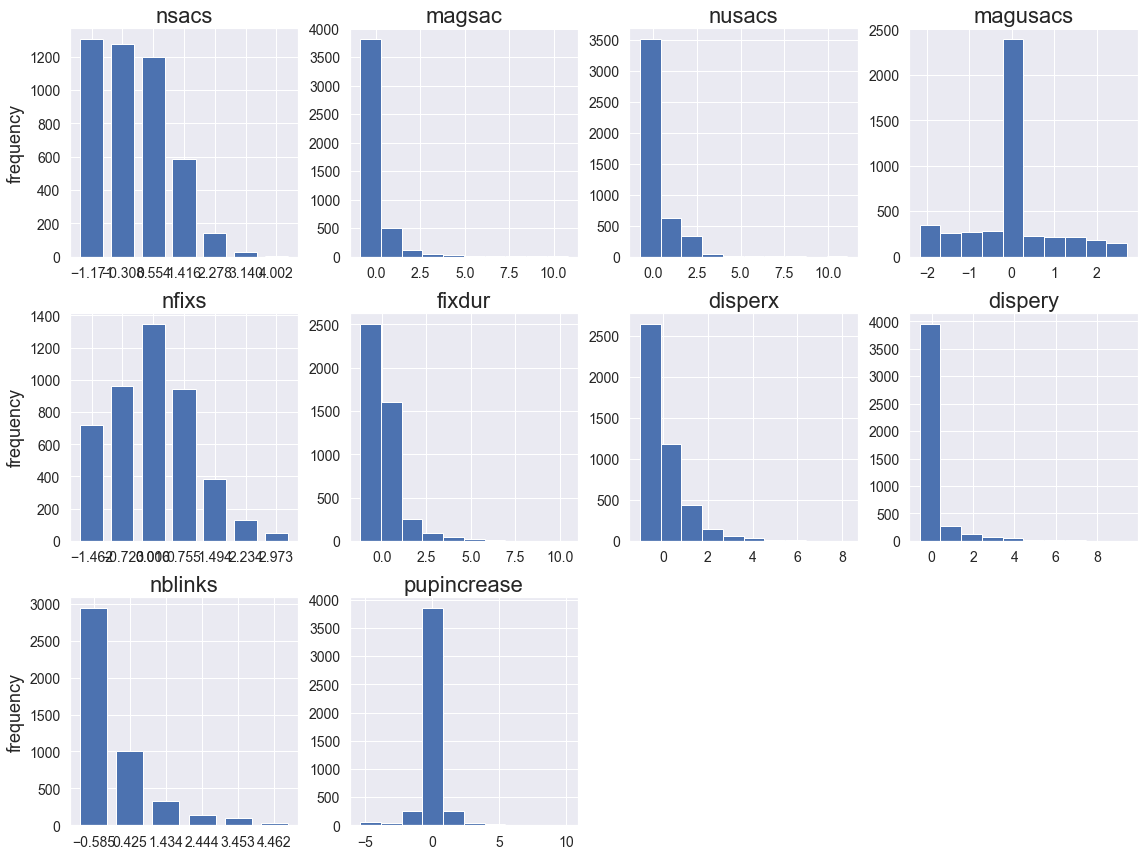

In [83]:

plt.figure(figsize = (16,12))

# get bins for discrete variables
def bin_edges(u): 
    u = sorted(u)
    d = (u[1] - u[0])
    edges = u - d/2
    edges = np.append(edges, edges[-1]+d)
    return edges

sp = 1     
values = df_feat.keys().values
for key in values[3:15]:
    plt.subplot(3, 4, sp)
    if len(df1[key].unique()) < 10:
        plt.hist(df_feat[key], bins=bin_edges(df_feat[key].unique()), rwidth=.75)
        plt.xticks(sorted(df_feat[key].unique()))
    else:    
        plt.hist(df_feat[key])
    if sp in [1, 5, 9]:
        plt.ylabel('frequency', fontsize=18)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.title(key, fontsize=22)
    sp = sp + 1
plt.tight_layout()
plt.show()

### Joint feature/diagnosis histograms
Next we can look at how predictive each variable is of a positive diagnosis.

We'll start by plotting 2D histograms with each variable as a function of diagnosis.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a548b6150>,
      dtype=object)

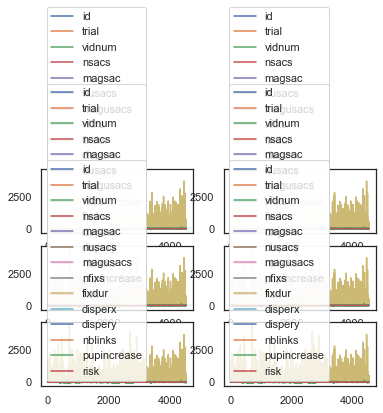

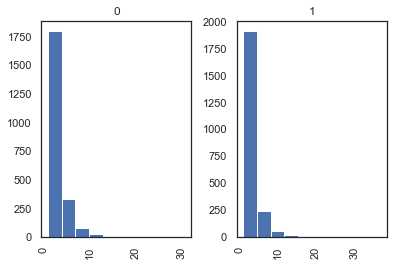

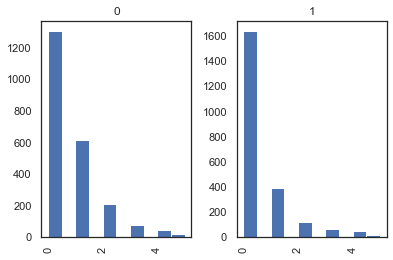

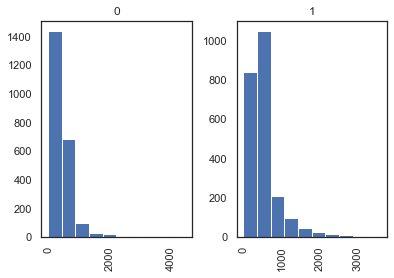

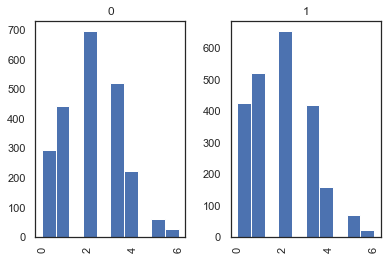

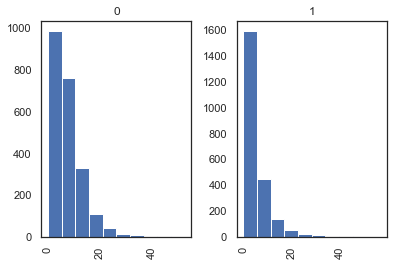

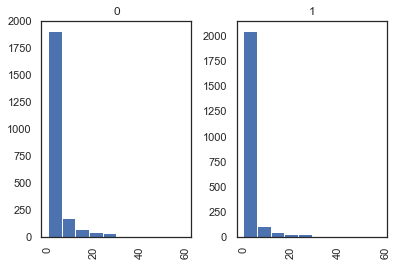

In [234]:
fig, axes = plt.subplots(nrows=3, ncols=2 )

df1.plot(ax=axes[0,0], legend='false')
df1['magsac'].hist(by=df1['risk'])
#df1.plot(kind='kde', legend='false')
df1.plot(ax=axes[0,1],legend='false')
df1['nblinks'].hist(by=df1['risk'])

#df1.groupby('risk')['nblinks'].plot(kind='kde', legend='false')
df1.plot(ax=axes[1,0],legend='false')
df1['fixdur'].hist(by=df1['risk'])

#df1.groupby('risk')['fixdur'].plot(kind='kde', legend='false')
df1.plot(ax=axes[1,1],legend='false')
df1['nfixs'].hist(by=df1['risk'])
df1.plot(ax=axes[2,0],legend='false')
df1['disperx'].hist(by=df1['risk'])
df1.plot(ax=axes[2,1],legend='false')
df1['dispery'].hist(by=df1['risk'])

#df1.groupby('risk')['nfixs'].plot(kind='kde', legend='false')
#fig.savefig('histograms.eps', format='eps', dpi=300,  transparent=True)


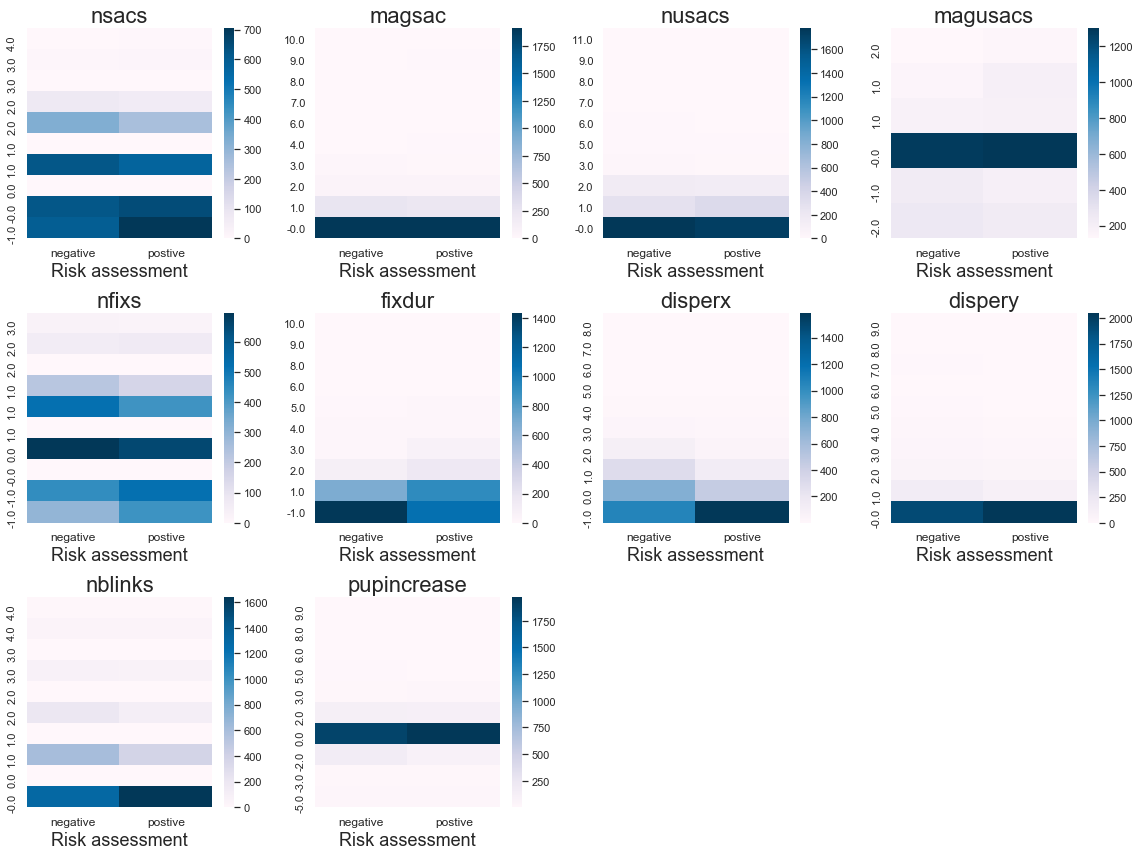

In [88]:
# look at joint histograms  - each as a function of Risk

# get bin centers from edge array
def bin_centers(a): 
    return a[:-1] + (a[1] - a[0])/2

# better bins for the variables
bins = {'risk': 2,
        'age': 10,        
        'male': 2,
        'nsacs': 10,
        'magsac': 10,
        'nusacs': 10,
        'magusacs': 6,
        'nblinks': 10,
        'nfixs': 10,
        'fixdur': 10,
        'disperx': 10,
        'dispery': 10,
        'pupincrease':10}

# create dict for result
H2d = dict.fromkeys(df_feat.keys())
# H2d.pop('risk')
H2d.pop('id')
H2d.pop('trial')
H2d.pop('vidnum')

plt.figure(figsize = (16,12))
sp = 1
for key in H2d.keys():
    H2d[key] = np.histogram2d(df_feat[key], df1['risk'], bins=(bins[key], bins['risk'] ))
    ax = plt.subplot(3, 4, sp)
    r = 0
    ytlabels = np.round(bin_centers(H2d[key][1][::-1]), r)
    sns.heatmap(np.flipud(H2d[key][0]), cmap='PuBu', ax=ax, annot=False, 
                yticklabels=ytlabels, xticklabels=['negative', 'postive'])
    ax.set_xlabel('Risk assessment', size=18)
    ax.set_title(key, size=22)
    sp = sp + 1
    #plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()

The features do not diverge substantially between risk assessments. Apparently better candidates may be fixdur, magsac, nblinks, and disperx

### Correlation

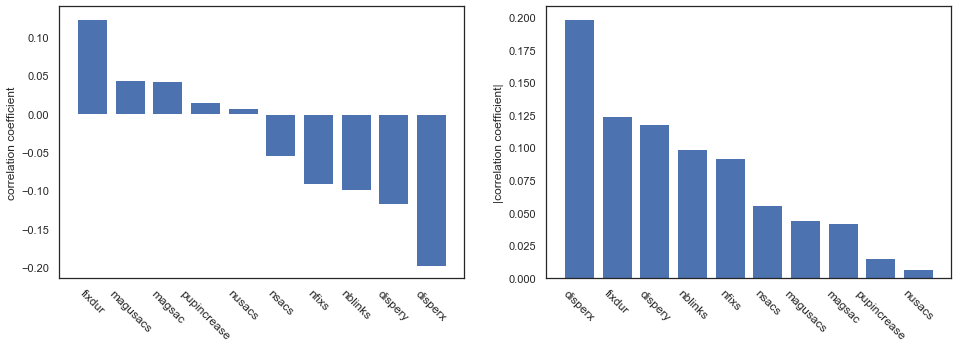

In [89]:
# correlate each one with hazard perception
Xvars = df_feat.keys().values[1:]
Y = df1['risk']

R = dict([(key,0) for key in H2d])
P = dict([(key,0) for key in H2d])

for key in H2d.keys():
    r, p = stats.pointbiserialr(df_feat[key], Y)
    R[key] = r
    P[key] = p

# get absolute value of the correlations and sort    
R_abs = dict([(key, abs(item)) for key, item in R.items()]) 
R_sort = list(zip(*sorted(R.items(), key=operator.itemgetter(1), reverse=True)))
R_sort_abs = list(zip(*sorted(R_abs.items(), key=operator.itemgetter(1), reverse=True)))

# plot corrs
sns.set_style('white')
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(1,2,1)
plt.bar(range(len(R_sort[1])), R_sort[1])
plt.xticks(range(len(R_sort[1])), R_sort[0], rotation=-45, fontsize=12 )
plt.ylabel('correlation coefficient', fontsize=12)

# plot abs corrs
ax2 = fig.add_subplot(1,2,2)
plt.bar(range(len(R_sort_abs[1])), R_sort_abs[1])
plt.xticks(range(len(R_sort_abs[1])), R_sort_abs[0], rotation=-45, fontsize=12 )
plt.ylabel('|correlation coefficient|', fontsize=12)

plt.show()

Disperx, Fixdur, Nblinks and Dispery have the highest magnitude correlations with diagnoses.

### Logistic Regression

In [91]:
# logistic regression
def do_log_reg(IV, DV):
    IV = IV.tolist()
    DV = DV.tolist()
    IN = np.ones((len(IV),1))
    X = np.column_stack((IV, IN))
    logit = sm.Logit(DV, X)
    return(logit.fit(disp=0))

result = {}

# logistic regression for the continuous variables
for key in H2d.keys():
    result[key] = do_log_reg(df_feat[key], df1['risk'])
    print('{}: params = {}, \n\tp = {}, \n\tr2 = {}\n'.format(key, result[key].params, 
                                                                   result[key].pvalues, 
                                                                   result[key].prsquared))


nsacs: params = [-0.11143097  0.00302877], 
	p = [1.85763618e-04 9.18860294e-01], 
	r2 = 0.002229670462192357

magsac: params = [0.08625047 0.00334315], 
	p = [0.0049745  0.91041677], 
	r2 = 0.001296255718069128

nusacs: params = [0.01370648 0.00308498], 
	p = [0.64438005 0.91723425], 
	r2 = 3.3869494558858015e-05

magusacs: params = [0.08896172 0.0031071 ], 
	p = [0.00282518 0.9167228 ], 
	r2 = 0.0014221515330659074

nfixs: params = [-0.18609149  0.00289641], 
	p = [5.90037181e-10 9.22605989e-01], 
	r2 = 0.00616966099420635

fixdur: params = [0.2715167  0.00740443], 
	p = [7.24976977e-16 8.04750816e-01], 
	r2 = 0.011611440830439856

disperx: params = [-0.45747784 -0.01014123], 
	p = [2.82935079e-37 7.38802148e-01], 
	r2 = 0.030552845834057374

dispery: params = [-0.26425134 -0.00198781], 
	p = [3.46020581e-14 9.47083240e-01], 
	r2 = 0.010637715396874858

nblinks: params = [-0.20342236  0.0016927 ], 
	p = [4.06979643e-11 9.54762855e-01], 
	r2 = 0.007187637791691737

pupincrease: params

This is giving us information similar to the correlations:

Nfixs, fixdur, disperx, dispery, nblinks have significant tests

Disperx has relatively higher $r^2$ values than the rest. The first parameter value is the regression slope which gives an indication of how the probability of a positive risk assesment changes with a unit change in the variable. Nblinks and Nfixs have an absolute slope bigger than the rest of features indicating that they may be a more sensitive indicator.

### Summary so far
Age and gender will likely not be useful due their non-representative distributions and low correlations with risk assesment.
Disperx and fixdur are most predictive followed by nblinks and dispery. These are our best candidates for inclusion into a predictive model.
In order to find the best combination of these variables, we need to consider the degree to which they're correlated with each other. We'll do that below.

### Joint feature/feature comparisons
First we'll calculate the correlation of each feature with the other features.

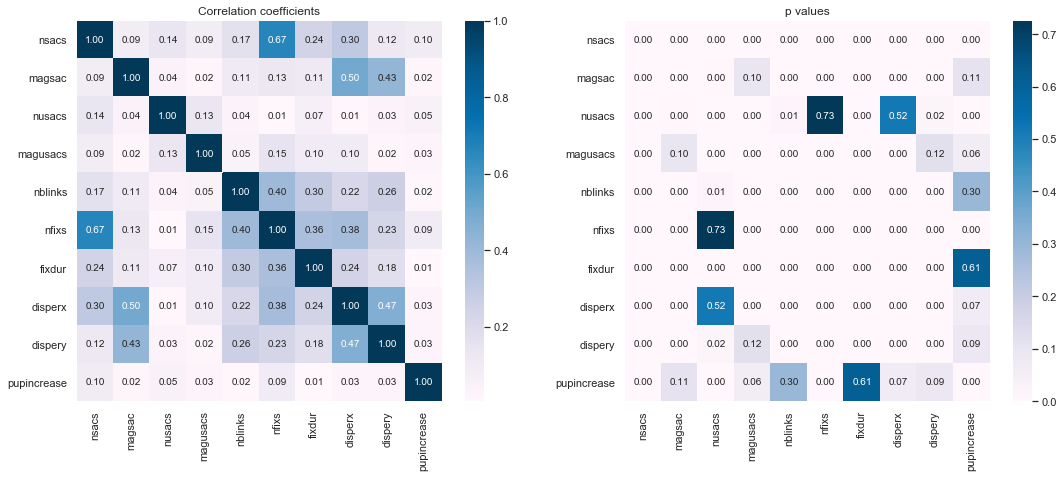

In [92]:
# get independent variables
Xvars = ['nsacs','magsac','nusacs','magusacs','nblinks','nfixs','fixdur','disperx','dispery','pupincrease']

R = np.zeros([len(Xvars), len(Xvars)])
P = np.zeros([len(Xvars), len(Xvars)])

# do point biserial correlation for dicho/cont variables
for i in range(len(Xvars)):
    for j in range(len(Xvars)):
        r, p = stats.pointbiserialr(df_feat[Xvars[i]], df_feat[Xvars[j]])
        R[i][j] = r
        P[i][j] = p

# plot
fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(1,2, 1)
sns.heatmap(abs(R), annot=True, fmt=".2f", xticklabels=Xvars, yticklabels=Xvars, cmap='PuBu', ax=ax1)
plt.title('Correlation coefficients')

ax2 = fig.add_subplot(1,2,2)
sns.heatmap(P, annot=True, fmt=".2f", xticklabels=Xvars, yticklabels=Xvars, cmap='PuBu', ax=ax2)
plt.title('p values')

plt.show()

Nfixs is highly correlated with Nsaccs, nblinks, and fixdur
Due to their high degree of multicolinearity, including nfixs in the predictive model may produce results that are misleading in terms of the relative importance placed on each variable in predicting the assessment.

However, it may possible to find optimal combinations of the variables that are more sensitive predictors than each variable alone. 


In [94]:
# leave-one-out CV
def cv_loo(X, Y, model):
    y_pred = []
    p_pred = np.empty((0,2))
    for i in range(X.shape[0]):      
        ind = list(range(X.shape[0]))
        ind_tr = [j for j in ind if j != i]
        ind_te = i
        if X.shape[1] > 1:
            X_train = X[ind_tr, :]
            X_test = X[i, :]
        else:    
            X_train = X[ind_tr]
            X_test = X[i]
        print(X_train, ' and test', X_test)
        Y_train = Y[ind_tr]
        Y_test = Y[i]
        model.fit(X_train, Y_train)
        y_pred.append(model.predict([X_test]))
        p_pred = np.vstack([p_pred,model.predict_proba([X_test])])
    result = {'y_pred': np.array(y_pred), 'y_true': Y, 'p_pred': p_pred}
    return result

# model performance
def results(y_test, y_pred, display):
    # accuracy, hits, true_negatives, misses, false_positives
    acc = sum(y_test == y_pred)/len(y_test)
    tpos = sum((y_test == 1) & (y_pred==1))/sum(y_test == 1)
    tneg = sum((y_test == 0) & (y_pred==0))/sum(y_test == 0)
    fneg = sum((y_test == 1) & (y_pred==0))/sum(y_test == 1)
    fpos = sum((y_test == 0) & (y_pred==1))/sum(y_test == 0)
    if display:
        # print the results
        print('accuracy = %.3f' % acc)
        print('hits = %.3f' % tpos)
        print('misses = %.3f' % fneg)
        print('true negatives = %.3f' % tneg)
        print('false positives = %.3f' % fpos)
    # save the results
    return {'acc': acc, 'tpos': tpos, 'tneg': tneg, 'fneg': fneg, 'fpos': fpos}


Applying to different combinations of features

In [177]:
d_prime = lambda h,f: norm.ppf(h) - norm.ppf(f)

features = [# [ 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks' ],
           # [ 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease'],
           # [ 'magsac', 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease'],
            [ 'magsac', 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease', 'nsacs'],
           # [ 'magsac', 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease', 'nsacs', 'magusacs'],
           # [ 'magsac', 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease', 'nsacs', 'magusacs', 'nusacs']

           ]

#[['nfixs', 'disperx'],
#            ['nfixs', 'dispery'],
#            [ 'nfixs','disperx', 'dispery', 'nblinks'],
#            [ 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks'],
#            [ 'magsac', 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks'],
 
Y = df1['risk'].values
dp = []
acc = []
hits= []
fps = []
probs = {}
for feature in features:
    X = df_feat[feature].values
    model = LogisticRegression()
    cv_result = cv_loo(X, Y, model)
    result = results(cv_result['y_true'], np.ravel(cv_result['y_pred']), False)
    acc.append(result['acc'])
    hits.append(result['tpos'])
    fps.append(result['fpos'])
    dp.append(d_prime(result['tpos'], result['fpos']))
    #probs[feature] = cv_result['p_pred']
    #flg, tlg2, threshold = roc_curve(cv_result['y_true'], np.ravel(cv_result['y_pred']))
    flg, tlg2, threshold = roc_curve(y_test, model.predict_proba(X_test)[:,1])

 


[[-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 ... -5.84917741e-01
  -2.47551188e-02 -1.17057654e+00]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.83938855  0.408632   -0.72291256 -0.72890879 -0.43536126 -0.58491774
  0.02566194 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 [ 4.36296363e-16  1.04451893e-15 -1.46202438

  -1.99287996e-02 -1.17057654e+00]]  and test [-0.52909628 -0.8080801   1.49442291  2.16178087  0.19527592  1.43404927
 -0.01145839  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.78502909 -0.23888109  0.75531109  0.41118164 -0.4644997   0.42456577
 -0.0491059  -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.

  -1.99287996e-02 -1.17057654e+00]]  and test [-0.84960532  0.33250546  0.01619926 -0.83249473 -0.53734558 -0.58491774
 -0.01614156 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.58945682  1.4822787   0.01619926 -0.61108012 -0.47282503 -0.58491774
 -0.09149587  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  4.74259459e+00 -7.22912560e-01 -8.35731784e-01
 -4.15241962e-01 -5.84917741e-01 -1.20830430e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

  -1.99287996e-02 -1.17057654e+00]]  and test [-0.7079397   0.9677683  -0.72291256 -0.58388879 -0.28550683 -0.58491774
 -0.12765634  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.72130569 -0.43576007  0.75531109 -0.73344074 -0.42772974  0.42456577
  0.22450672  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.4906398  -0.17675484  0.01619926  0.02920921 -0.07182576  0.42456577
 -0.15814495 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16 -1.50504305e-01  1.61992629e-02 -6.86827278e-01
 -2.48736979e-01  1.43404927e+00 -4.82417002e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.51285912  0.11331353  0.01619926  1.05341323 -0.39373504 -0.58491774
  0.01292648  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.58751528 -0.49701131  1.49442291  0.72825663 -0.33296212  0.42456577
  0.33329006  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.62656135 -0.92489496  2.97264656  1.51760697  0.49914734  0.42456577
 -0.2128224   1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -1.02372144e+00
 -4.97184411e-01 -5.84917741e-01 -3.07380301e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.56005623  1.42452753 -0.72291256 -0.59942681 -0.4915567  -0.58491774
 -0.01169464 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.58203071e+00 -7.22912560e-01  9.36231920e-01
 -1.89073007e-01  4.24565767e-01 -4.44822666e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.50180548 -0.00350133 -0.72291256 -0.67711611 -0.54220195 -0.58491774
  0.10816143 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.52591615  0.06650008  0.75531109 -0.2355818  -0.2369429  -0.58491774
  0.27543053  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -8.95293468e-01
 -5.38039182e-01 -5.84917741e-01 -3.07932841e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.06071322 -0.39200919  0.75531109 -0.22910769 -0.3978977  -0.58491774
 -0.0804588   1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.87973143 -0.17806736  0.01619926  0.42024546  3.88127755  0.42456577
 -0.30889158 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.47296458 -0.5757629   0.01619926  2.68424127 -0.28273179 -0.58491774
 -0.11615324  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.43828241 -0.60595101  0.01619926  0.52706825  3.59266905  0.42456577
 -0.21374137  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -9.10831488e-01
 -3.98591517e-01 -5.84917741e-01  9.24502739e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.04887617  0.93101755  0.01619926  0.19429899 -0.39165381 -0.58491774
 -0.12146119  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.86250109  0.87064133  0.01619926 -0.83637904 -0.28758827 -0.58491774
  0.30251405  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.37721687 -0.47601088 -0.72291256 -0.2673051  -0.39512245 -0.58491774
  0.39028003 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -1.74910900e-02
 -1.88359714e-01  4.24565767e-01 -7.01652909e-04 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16 -1.30816407e-01  1.61992629e-02  7.51754272e-02
  1.39774295e-01  4.24565767e-01 -1.13791405e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.68210532 -0.60288845  0.75531109 -0.46347052 -0.27440625  0.42456577
  0.14481079  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.566

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00  2.17834277e+00
  1.12474828e+00 -5.84917741e-01 -1.34263875e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.37753397 -0.67989     0.75531109  1.40310179  0.23620854  1.43404927
 -0.2823158  -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 5.91793478 -1.05652262  0.         -0.24464552  2.99325165  4.4624998
 -1.08893159 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -1.04373417e+00
 -5.33950381e-01 -5.84917741e-01 -1.11399637e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.32889478  2.81580565 -0.72291256  0.07841258 -0.05378758 -0.58491774
  0.01003978 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -9.50323394e-01
 -5.00575680e-01 -5.84917741e-01  5.20829911e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.58168757 -0.31413261  0.75531109 -0.14095089  1.43419224 -0.58491774
  0.09597571  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -9.02415027e-01
 -4.71437400e-01 -5.84917741e-01 -9.78391869e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.73035896 -0.88223784  1.49442291  0.29464788 -0.13218354 -0.58491774
  0.00689468  3.14002456]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.90194253 -0.81004889  1.49442291  0.7439509   0.42491394  0.42456577
 -0.36322977  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.78280661 -0.09537819  0.01619926 -0.46152817 -0.45548056 -0.58491774
  0.96795728  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.70095453 -0.79626736 -0.72291256 -0.18184658 -0.05725665 -0.58491774
 -0.17371283 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

  -1.99287996e-02 -1.17057654e+00]]  and test [-0.88858839  0.15925196  0.01619926 -0.86745478 -0.06325918 -0.58491774
  4.03468724 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.62243609 -0.50751152  0.01619926 -0.63373951 -0.15715932  0.42456577
  2.47913754  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.90440481 -0.41235335  1.49442291 -0.82343102 -0.39859146  2.44353278
 -0.16413165 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

  -1.99287996e-02 -1.17057654e+00]]  and test [-0.82116666  4.19658356 -0.72291256 -0.82278337 -0.49918821 -0.58491774
  0.157308   -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.83734539 -0.28963212 -0.72291256 -0.97880943 -0.35419021 -0.58491774
  1.37229972 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.86023739 -0.61251364  0.01619926 -0.16300037 -0.00597913  0.42456577
  2.19647079 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.32911888 -0.47863594  0.01619926  0.56244374  0.28731215 -0.58491774
 -2.14376433 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

  -1.99287996e-02 -1.17057654e+00]]  and test [-0.66627542 -0.34475823  0.75531109  0.13926907 -0.21682366 -0.58491774
  0.43944897  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16 -3.48695810e-01  1.61992629e-02 -4.75123835e-01
 -2.20986272e-01  1.43404927e+00 -2.11127950e+00 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.566

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.4928403  -0.75951661  1.49442291  2.0756751  -0.17103472  0.42456577
 -0.06541366  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.01040312 -0.91491975  2.23353473  0.78603271 -0.10165769  1.43404927
 -0.03541015  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -8.04008492e-01
 -4.58949619e-01 -5.84917741e-01 -5.96760182e-03 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -7.66458838e-01
 -5.62321355e-01 -5.84917741e-01 -4.76553541e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.48567608  0.8443908  -0.72291256 -0.67711592 -0.5054321  -0.58491774
 -0.00449247 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.84287289  0.00699888 -0.72291256 -0.79365008 -0.48461899 -0.58491774
  0.00123036 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -9.72982776e-01
 -5.48445948e-01 -5.84917741e-01 -1.52395162e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.2851945  -0.45763551  0.01619926 -0.10804178 -0.39026619  1.43404927
  1.79763114 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.63113898 -0.56198137  1.49442291 -0.53857022 -0.14328391 -0.58491774
  0.3192224   0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.01414642  0.6658872  -0.72291256 -0.04200598 -0.51236981 -0.58491774
 -0.00748165 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.89313309 -0.23319348  0.01619926 -0.17796208 -0.43466745 -0.58491774
  0.04050686  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.63566611 -0.79889241  0.75531109 -0.76127943 -0.20294841  4.4624998
  0.64337886 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.90402407  0.14743922  0.01619926 -0.7353829  -0.39720389  0.42456577
 -0.11338281 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16 -2.14818104e-01  1.61992629e-02 -5.79357029e-01
 -1.28551759e-02  1.43404927e+00  2.77825860e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.57720311  1.58990587  0.01619926 -0.47836089 -0.38818496 -0.58491774
 -0.01113996  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.62610867 -0.40382192  0.01619926 -0.58065173 -0.48808785 -0.58491774
 -0.03163401  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 1.38106186  0.06387503  0.75531109  0.23832295 -0.30423882 -0.58491774
 -0.23993706 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -9.49028691e-01
 -5.54689839e-01 -5.84917741e-01 -1.97428436e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.07156041  0.16975217  0.01619926 -0.06272301  0.04680911 -0.58491774
 -0.15670739  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.566

  -1.99287996e-02 -1.17057654e+00]]  and test [-0.33739103  0.47557085  0.01619926 -0.44087781 -0.51167599 -0.58491774
 -1.00513224 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  2.71605363e+00 -7.22912560e-01 -9.23732637e-01
 -5.28085117e-01 -5.84917741e-01  2.08163597e+00 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.566

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.12933952 -0.39988434  1.49442291 -0.32233482  0.0343616  -0.58491774
 -0.89080843  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.13881653 -0.7614854   1.49442291  0.4908133  -0.1689535   1.43404927
 -0.28379544  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.25395684 -0.54951237  0.01619926  1.30849314 -0.31048281  0.42456577
 -0.80547413 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.68424786 -0.39463424  0.01619926 -0.06725497 -0.35696509  0.42456577
 -0.64996728 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.26372511 -0.54688732  0.75531109 -0.11645804 -0.18213509  0.42456577
  0.17872498 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16 -8.12892692e-01  7.55311086e-01 -8.88171909e-01
 -1.90460420e-01  2.44353278e+00  2.47104832e+00 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16 -4.58948039e-01  1.61992629e-02  1.54415081e+00
  6.47944740e+00  2.44353278e+00  2.97712408e+00 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.46455886 -0.30669496  0.01619926 -0.61172757 -0.4582557  -0.58491774
  0.48408174  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16 -1.10077351e+00 -7.22912560e-01 -7.40562303e-01
 -2.94525969e-01  4.24565767e-01 -1.29352156e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.31079925  0.3692562   0.01619926 -0.10868933 -0.43050478 -0.58491774
  0.09342316  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

  0.02767007  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.21329833 -0.42613488  0.75531109 -0.53792277  0.00610938  0.42456577
 -0.23084667 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.72375942 -0.43794761  0.01619926 -0.15029913  1.43324433  1.43404927
 -1.29588051 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.04070368  0.19994028  0.01619926 -0.30654605 -0.08178016 -0.58491774
 -0.14957589 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.8221337  -0.83761194  1.49442291 -0.75674758 -0.17727883  2.44353278
  1.93473654  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.74175522 -0.98964626  0.75531109  0.54649048 -0.14536535  1.43404927
 -0.0324624  -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.64449587 -0.26994422  0.01619926 -0.64086106 -0.48045633 -0.58491774
  0.0010929   0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.14731365 -0.67918999  2.23353473  0.03309372 -0.2300052   4.4624998
 -0.10660312 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16 -1.78504870e-01  7.55311086e-01 -6.04606015e-01
 -2.25842749e-01  4.24565767e-01  1.75584624e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.5661

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.8594033   2.83680607 -0.72291256 -0.86615998 -0.43327982 -0.58491774
  0.96803604 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.31712441 -0.23581853  0.01619926 -0.2304026  -0.35002759 -0.58491774
  0.03423352  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16 -3.08007488e-01 -7.22912560e-01  1.98183596e-01
 -4.56174369e-01 -5.84917741e-01 -2.03677198e+00 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.30628287 -0.209568    1.49442291 -0.50037282 -0.29938245 -0.58491774
  0.15982001  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16 -9.88552493e-01  1.49442291e+00 -6.96538441e-01
 -4.04141595e-01  3.45301629e+00 -3.16267387e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.98103878e+00 -7.22912560e-01 -2.92554081e-01
 -4.92944323e-01  4.24565767e-01  1.92216313e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 6.69344298 -0.31982023  0.01619926  3.27597506  3.44836512  0.42456577
  0.36883706 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16 -6.44670542e-01  1.49442291e+00  2.54310565e+00
  2.11216329e+00  2.44353278e+00 -1.72309655e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.53133105 -0.97267092  2.23353473  1.4651667   0.40479443  3.45301629
 -0.94921452 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.566

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.03903423 -0.64073296  1.49442291 -0.4123249  -0.12593987  2.44353278
 -0.31537298 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.66603241e+00 -7.22912560e-01 -1.72782867e-01
 -3.00076046e-01  4.24565767e-01  2.73644513e+00 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00  2.42462953e+00
 -1.91848046e-01  4.24565767e-01  9.01565520e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16 -7.41141242e-01  1.61992629e-02 -7.83375757e-01
 -2.64950246e-01  4.24565767e-01 -1.11399637e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16 -1.03462217e+00  2.23353473e+00 -1.00794302e+00
 -2.52899643e-01  3.45301629e+00 -6.51731955e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 1.00531282 -0.15444188  0.01619926  0.79962798 -0.40275408 -0.58491774
 -0.1593797   0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -9.41987697e-02
 -1.51218733e-02 -5.84917741e-01 -5.39733125e+00 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.56268221  1.00320651  0.01619926  1.95935    -0.34283893 -0.58491774
 -0.03185133  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.3626863  -1.01720932  2.97264656  0.4069822   0.96327959  3.45301629
 -0.46843703  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -9.91758960e-01
 -4.24263519e-01 -5.84917741e-01 -2.09588176e+00 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -3.89665715e-01
 -5.40120620e-01 -5.84917741e-01 -7.34714907e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -6.61578095e-01
 -4.71437400e-01 -5.84917741e-01  3.12210281e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.27159882 -0.04025208  0.75531109  0.40729724 -0.363903    0.42456577
  0.11315369  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.93891246 -0.2292559   0.75531109  2.23623282 -0.1897665  -0.58491774
  0.04048062  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.77274771 -0.42438484  0.75531109 -0.42225313 -0.424261   -0.58491774
 -0.87259741  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.77410633 -0.19250515  0.01619926 -0.56770351 -0.3104826  -0.58491774
  1.12924171 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.38375875  0.12118869  0.01619926 -0.92895872 -0.14675276  0.42456577
 -0.47737473 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -8.12424952e-01
 -5.17919885e-01 -5.84917741e-01 -1.29410947e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  7.99764902e-01 -7.22912560e-01 -9.27664013e-01
 -4.61030846e-01  4.24565767e-01 -9.31837930e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  5.87135604e-01 -7.22912560e-01 -2.87857170e-01
 -4.81747626e-01 -5.84917741e-01 -1.11399637e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  2.95755851e+00 -7.22912560e-01 -9.65861216e-01
 -5.51220987e-01 -5.84917741e-01 -3.29573748e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.06831588  0.11068847  0.01619926  0.01820335 -0.20156068 -0.58491774
 -0.01242206 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.86092437  3.04156021 -0.72291256 -0.47577129 -0.37500316 -0.58491774
  0.31128384 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -7.45122668e-01
 -5.10535660e-01 -5.84917741e-01  5.63127484e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.93377646e-01 -7.22912560e-01 -1.74289630e-01
 -2.88144889e-01 -5.84917741e-01 -9.73755944e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16 -1.21890090e+00 -7.22912560e-01 -5.48599999e-01
 -2.57779163e-01  4.24565767e-01 -1.36020534e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.88891111  6.40950328 -0.72291256 -0.44283971 -0.14293715 -0.58491774
  0.07243704 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.566

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.03363596 -0.49088618  0.75531109 -0.03294227 -0.46935596 -0.58491774
 -0.05045044  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -9.06299532e-01
 -4.18017107e-01 -5.84917741e-01  6.18074154e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.99940278e-01  1.61992629e-02 -1.19858364e-01
 -3.97203891e-01 -5.84917741e-01 -6.23188180e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.41853072  0.26687913  0.01619926 -0.64150851 -0.49363814 -0.58491774
 -0.00705578 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.48490375e+00 -7.22912560e-01 -9.03062280e-01
 -4.28423556e-01 -5.84917741e-01 -8.60114596e-03 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.33035488 -0.57488788  0.75531109 -0.48548245 -0.30493252 -0.58491774
  0.05860537  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  6.86887620e-01 -7.22912560e-01 -7.96239680e-01
 -4.20098439e-01 -5.84917741e-01 -1.92421843e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.11452963 -0.30275738  0.01619926 -0.01481465 -0.4249547  -0.58491774
 -0.00334578  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.33827162 -0.12687883  0.01619926 -0.41426705 -0.01493661  0.42456577
 -1.08833758 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-5.17154323e-01  1.04451893e-15 -1.46202438e+00 -4.53759355e-01
 -4.05529220e-01 -5.84917741e-01 -6.59339715e-02 -3.08456320e-01]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -9.79457082e-01
 -5.08207143e-01 -5.84917741e-01 -1.71090759e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.5549936   2.17791776 -0.72291256 -0.66093084 -0.48808785 -0.58491774
 -0.01464708 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.64012233 -0.45063537  0.75531109 -0.35535282 -0.37430956 -0.58491774
 -0.04521579  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.55467615 -0.38413403  0.75531109 -0.1630717  -0.39651008 -0.58491774
  0.02953055 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 2.85698703 -0.53813714  0.75531109  0.91292509  3.0362656   0.42456577
 -0.0185477   0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 1.14603873 -0.16625462 -0.72291256  0.21566367 -0.10582036 -0.58491774
 -0.04118485 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.03934343  0.14350164  0.01619926 -0.27766351  0.17515662 -0.58491774
  0.01759229  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 1.8229007  -0.11112851  0.01619926 -0.65445654  1.88044393 -0.58491774
 -0.0050615   0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 1.48370115 -0.1155036   0.75531109  0.16775511  3.19167    -0.58491774
 -0.02718701  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.46698357 -0.11112851  0.75531109 -0.41685685 -0.09610761 -0.58491774
 -0.05485143  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.43470287  0.20475288  0.75531109 -0.31521346 -0.02326173 -0.58491774
  0.01790038  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.19370472 -0.36707118  0.01619926 -0.13523311  0.30489155 -0.58491774
  0.02987861  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.30587077e-01 -2.52006356e-01  7.55311086e-01 -2.84103164e-02
  5.65055417e-01 -5.84917741e-01 -1.37738682e-05  1.41578412e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.84091903 -0.86976884  1.49442291  2.50879305  4.91013906  0.42456577
 -0.10299911  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 1.1080615  -0.64270175  1.49442291  3.33100479  2.4201973  -0.58491774
  0.58176362  2.27790434]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.3524898  -0.65101442  0.75531109  0.9893195   0.27020324 -0.58491774
  0.04558691  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.57628528  0.24325365  1.49442291 -0.40779314 -0.51236981 -0.58491774
 -0.01113996  2.27790434]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.35211851 -0.47469836  0.01619926  0.31730711 -0.36737185 -0.58491774
  0.00796583  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 1.54034847 -0.04025208  0.01619926  0.49405036 -0.38887877 -0.58491774
  0.4769334  -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 1.0149355  -0.6007009   0.01619926  1.245047   -0.17658501 -0.58491774
 -0.02260383  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.22627863 -0.01925165  0.01619926 -0.35211576 -0.48808785 -0.58491774
  0.01619335 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.39104258 -0.5215118   0.75531109 -0.20515361 -0.45756199  0.42456577
 -0.00442611  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.55031263 -0.65057691  1.49442291 -0.35341067 -0.03644343 -0.58491774
 -0.07703689  2.27790434]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.31821288e+00  1.61992629e-02 -6.78410817e-01
 -7.80695438e-02  1.43404927e+00  7.05520483e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.20053003 -0.6597646   0.01619926  0.5264208  -0.46796855  0.42456577
  0.13437565  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.78940990e+00 -7.22912560e-01 -5.76767425e-01
 -4.18017001e-01 -5.84917741e-01  5.45260075e-03 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.83559109 -0.62432638  0.01619926  0.57627142 -0.29383216  1.43404927
 -0.31179052 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -1.03428498e+00
 -5.77125050e-01 -5.84917741e-01 -1.11399637e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -1.03428498e+00
 -5.77125050e-01 -5.84917741e-01 -1.11399637e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.52440743  0.03587446 -0.72291256 -0.58777349 -0.45894941 -0.58491774
 -0.01325387 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.05538044 -0.27475682  0.75531109  0.25968753 -0.39442885 -0.58491774
 -0.02240571  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.66144318e-01 -5.96763324e-01  1.61992629e-02  1.14146115e+00
  3.58311946e-01 -5.84917741e-01  4.42158843e-04  5.53663900e-01]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  4.33570001e-01  1.61992629e-02  7.38124146e-01
  4.08263494e-01  4.24565767e-01 -1.66897645e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.46739036 -0.24325618  0.75531109 -0.56446666 -0.51306362 -0.58491774
  0.03818136  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.17240411  1.31952541 -0.72291256 -0.17602012 -0.1155331  -0.58491774
 -0.04423254 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -9.74277676e-01
 -3.97897704e-01 -5.84917741e-01 -1.85102102e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.34935236 -0.61251364  0.01619926 -0.24723512 -0.21890483  0.42456577
 -0.16377676  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -8.61628220e-01
 -5.22082549e-01 -5.84917741e-01  6.43923326e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -6.38918911e-01
 -5.23469963e-01 -5.84917741e-01 -4.92341649e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.81874556 -1.10602362 -0.72291256 -0.30873935 -0.48115014 -0.58491774
  0.04726645 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.566

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.76232413 -0.11287854  0.75531109 -0.52950631 -0.21959865 -0.58491774
 -0.17849826  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.68401852 -0.234506    0.01619926 -0.62920775 -0.31880793  0.42456577
 -0.4361261   0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.50881197 -0.52588689 -0.72291256 -0.07372908 -0.46437777  0.42456577
 -0.26040863 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.33053465 -0.48738611  0.75531109  0.9919092  -0.11553331 -0.58491774
  0.11572206  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.14253872 -0.66588972  0.75531109  0.55276386 -0.41454826 -0.58491774
 -0.29494513  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.742167   -0.67113983  0.75531109 -0.42397841 -0.22167998  0.42456577
  0.18548271 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.69764928  3.2043135  -0.72291256 -0.78329146 -0.37361574 -0.58491774
 -0.05236728 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.75736573  1.26702435 -0.72291256 -0.7722856  -0.52208255 -0.58491774
 -0.11615687 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

  -1.99287996e-02 -1.17057654e+00]]  and test [-0.84271172  1.94953814 -0.72291256 -0.82019376 -0.52069514 -0.58491774
 -0.017591   -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.34230445  1.36940142 -0.72291256 -0.61237502 -0.44854285 -0.58491774
 -0.07480218 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 1.08658924  0.03587446  0.01619926  2.05560552 -0.33198952 -0.58491774
 -0.04549381  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.26029862 -0.63745165  0.01619926 -0.66222555  1.16586066  0.42456577
 -0.21386641  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

  -1.99287996e-02 -1.17057654e+00]]  and test [-0.66609728  0.39550673 -0.72291256 -0.73214604 -0.49780059 -0.58491774
 -0.02339135 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -1.00729547e+00
 -5.56077253e-01 -5.84917741e-01  7.66086008e-02 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.566

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.56070518 -0.38238399  0.75531109 -0.59942681 -0.50751333 -0.58491774
 -0.01064759  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

 -0.02224078  1.41578412]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.18842852  0.20912796 -0.72291256  0.19106194 -0.16409723 -0.58491774
 -0.00536174  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.5634906  -0.93627019  0.75531109 -0.1973846   0.27228436  0.42456577
  0.33230393  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

  -1.99287996e-02 -1.17057654e+00]]  and test [-0.73354038 -0.22400579  0.01619926 -0.67323161 -0.19392917 -0.58491774
 -0.02580049  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 1.56681696 -0.41563466  0.01619926  1.21526606 -0.24804348 -0.58491774
 -0.01237352  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -9.24615805e-01
 -2.07631583e-01  4.24565767e-01 -1.26956776e+00 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.70095203 -0.30210112  1.49442291  0.70251674  0.1265927  -0.58491774
 -0.05557581  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

  -1.99287996e-02 -1.17057654e+00]]  and test [-0.09647824  0.06868763  0.01619926  0.63259615  0.08011    -0.58491774
  0.18357642  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  8.98641900e-01  7.55311086e-01 -5.22384752e-01
  4.26464497e-02  1.43404927e+00  4.24000023e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.566

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 1.36177049e-04 -5.35074577e-01  1.49442291e+00  9.13606996e-02
 -1.32183544e-01  1.43404927e+00 -1.91016484e-02 -3.08456320e-01]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 0.05728135  0.08837552  0.01619926 -0.48418755  0.68039489  0.42456577
  0.72398651 -0.30845632]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

  -1.99287996e-02 -1.17057654e+00]]  and test [-0.11522025 -0.54338725  0.75531109 -0.10923055 -0.12802109 -0.58491774
 -0.04823232  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [ 4.36296363e-16  1.04451893e-15 -1.46202438e+00 -9.17247330e-01
 -4.73521533e-01  4.24565767e-01  4.53558396e-01 -1.17057654e+00]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.566

[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629e-02 ... -5.84917741e-01
   4.84910916e-03  5.53663900e-01]
 ...
 [ 4.36296363e-16 -1.22021343e+00  1.61992629e-02 ...  2.44353278e+00
   2.30917919e-01 -1.17057654e+00]
 [ 4.36296363e-16 -1.16289977e+00  7.55311086e-01 ...  2.44353278e+00
  -3.65847794e-02 -1.17057654e+00]
 [ 4.36296363e-16 -1.16587483e+00  2.23353473e+00 ...  4.46249980e+00
  -1.99287996e-02 -1.17057654e+00]]  and test [-0.42971144 -0.87851902  2.97264656 -0.1235796  -0.05517521  3.45301629
 -0.02148465  0.5536639 ]
[[-8.39388552e-01  4.08631996e-01 -7.22912560e-01 ... -5.84917741e-01
   2.56619400e-02 -3.08456320e-01]
 [-9.00031846e-01  2.28291988e+00 -7.22912560e-01 ... -5.84917741e-01
   6.16628759e-02 -3.08456320e-01]
 [ 3.99306940e-02 -1.61004517e-01  1.61992629

In [173]:
print(acc)

[0.6569729015201586]


In [171]:
data = np.array([acc, hits, fps, dp]).T;
index = [' | '.join(f) for f in features]
columns = ['accuracy', 'Hits', 'FP', 'd\'']
print(data)
table = pd.DataFrame(data, columns = columns, index = index)
table

[[0.61775722 0.71095469 0.47572816 0.61705395]
 [0.61951972 0.71447426 0.47572816 0.62738169]
 [0.65499009 0.7558293  0.44616064 0.82831681]
 [0.6569729  0.76066872 0.44704325 0.84159045]
 [0.65454946 0.75626925 0.44748455 0.82637117]
 [0.65300727 0.75274967 0.44704325 0.8163032 ]]


accuracy      Hits  \
fixdur | nfixs | disperx | dispery | nblinks        0.617757  0.710955   
fixdur | nfixs | disperx | dispery | nblinks | ...  0.619520  0.714474   
magsac | fixdur | nfixs | disperx | dispery | n...  0.654990  0.755829   
magsac | fixdur | nfixs | disperx | dispery | n...  0.656973  0.760669   
magsac | fixdur | nfixs | disperx | dispery | n...  0.654549  0.756269   
magsac | fixdur | nfixs | disperx | dispery | n...  0.653007  0.752750   

                                                          FP        d'  
fixdur | nfixs | disperx | dispery | nblinks        0.475728  0.617054  
fixdur | nfixs | disperx | dispery | nblinks | ...  0.475728  0.627382  
magsac | fixdur | nfixs | disperx | dispery | n...  0.446161  0.828317  
magsac | fixdur | nfixs | disperx | dispery | n...  0.447043  0.841590  
magsac | fixdur | nfixs | disperx | dispery | n...  0.447485  0.826371  
magsac | fixdur | nfixs | disperx | dispery | n...  0.447043  0.816303

In [180]:
features = [ [ 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks' ],
            [ 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease'],
            [ 'magsac', 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease'],
            [ 'magsac', 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease', 'nsacs'],
            [ 'magsac', 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease', 'nsacs', 'magusacs'],
            [ 'magsac', 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease', 'nsacs', 'magusacs', 'nusacs']
           ]

Y = df1['risk'].values
logmodel = LogisticRegression()
dp = []
acc = []
hits= []
fps = []
probs = {}
for feature in features:
    X = df_feat[feature]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    logmodel.fit(X_train,y_train)
    predictions = logmodel.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test, predictions)))
    flg, flg2, threshold = roc_curve(y_test, logmodel.predict_proba(X_test)[:,1])

 

Test accuracy is 0.6208277703604806
Test accuracy is 0.6188251001335113
Test accuracy is 0.6588785046728972
Test accuracy is 0.6548731642189586
Test accuracy is 0.6555407209612817
Test accuracy is 0.6622162883845126


##  Random Forest Classifier 

In [130]:
feats = [   [ 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks' ],
            [ 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease'],
            [ 'magsac', 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease'],
            [ 'magsac', 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease', 'nsacs'],
            [ 'magsac', 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease', 'nsacs', 'magusacs'],
            [ 'magsac', 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease', 'nsacs', 'magusacs', 'nusacs']
        ]
acc = []
logmodel = LogisticRegression()
for feature in feats:
    x = df_feat[feature]
    y = df1['risk']
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)    
    logmodel.fit(X_train,y_train)
    print('Test accuracy is {}'.format(accuracy_score(y_test, test_predictions)))
    predictions = logmodel.predict(X_test)
    

              precision    recall  f1-score   support

           0       0.63      0.71      0.66       668
           1       0.68      0.59      0.63       694

    accuracy                           0.65      1362
   macro avg       0.65      0.65      0.65      1362
weighted avg       0.65      0.65      0.65      1362

0.6490455212922174
MAE: 0.3509544787077827
MSE: 0.3509544787077827
RMSE: 0.592414110827707
[[472 196]
 [282 412]]
Test accuracy is 0.6490455212922174
              precision    recall  f1-score   support

           0       0.66      0.71      0.69       680
           1       0.69      0.63      0.66       682

    accuracy                           0.67      1362
   macro avg       0.68      0.67      0.67      1362
weighted avg       0.68      0.67      0.67      1362

0.6740088105726872
MAE: 0.32599118942731276
MSE: 0.32599118942731276
RMSE: 0.5709563813701646
[[485 195]
 [249 433]]
Test accuracy is 0.6740088105726872
              precision    recall  f1-score

In [131]:
data = np.array([acc]).T;
index = [' | '.join(f) for f in feats]
columns = ['accuracy']
table = pd.DataFrame(data, columns = columns, index = index)
table.head()

ns_probs = [0 for _ in range(len(y_test))]

In [ ]:
fpr2, tpr2, threshold = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])


print(acc)
data = np.array([acc]).T;
index = [' | '.join(f) for f in feats]
columns = ['accuracy']
table = pd.DataFrame(data, columns = columns, index = index)
table.head()


# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Chance')
pyplot.plot(fpr2, tpr2, marker='.', label='Random Forest')
#pyplot.plot(fplo, tplo, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [56]:
nfixs = tf.feature_column.numeric_column("nfixs")
disperx = tf.feature_column.numeric_column('disperx')
dispery = tf.feature_column.numeric_column('dispery')
nblinks =tf.feature_column.numeric_column('nblinks')
fixdur = tf.feature_column.numeric_column('fixdur')
magsac = tf.feature_column.numeric_column('magsac')
feat_cols = [nfixs, disperx, dispery, nblinks, fixdur]
classifier = tf.estimator.DNNClassifier(hidden_units=[10, 20, 10], n_classes=2,feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/c9/s6yf48_d36d3lvtfmcc3btb00000gq/T/tmpb3j5qlqb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Neural network

Define a neural network with 3 hidden layers: 2 rectified linear units and one sigmoid (this is a binary classification problem)

The below code compiles the network. It uses Adam, a momentum-based optimizer. The loss function used is binary_crossentropy. For binary classification problems that give output in the form of probability, binary_crossentropy is usually the optimizer of choice. mean_squared_error may also be used instead of binary_crossentropy as well. Metrics used is accuracy. The model is trained for 50 epochs with a batch size of 1. Finally, the trained model was evaluated for the test set to check the accuracy.

In [3]:
feats = [ #[ 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks' ],
            [ 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease'],
           # [ 'magsac', 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease'],
           # [ 'magsac', 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease', 'nsacs'],
           # [ 'magsac', 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease', 'nsacs', 'magusacs'],
           # [ 'magsac', 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease', 'nsacs', 'magusacs', 'nusacs']
           ]
accN = []
accuracy = 0

for feature in feats:
    x = df_feat[feature]
    y = df1['risk']
    model = keras.Sequential([
    keras.layers.Flatten(input_shape=(len(feature),)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
    ])
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
    model.fit(X_train, y_train, epochs=100, batch_size=30)
    test_loss, test_acc = model.evaluate(X_test, y_test)
    test_predictions = model.predict(X_test).flatten()
    test_predictions = np.where(test_predictions > 0.5, 1, 0)
    print('Test accuracy is {}'.format(accuracy_score(y_test, test_predictions)))
    accN.append(accuracy_score(y_test, test_predictions))
    accuracy = accuracy_score(y_test, test_predictions)
    fnn2, tnn2, fthreshold = roc_curve(y_test, test_predictions)

    

In [154]:
print(accN)

[0.6740088105726872, 0.7268722466960352, 0.6475770925110133, 0.6850220264317181, 0.6607929515418502, 0.6651982378854625]


In [186]:
x= df_feat[[ 'magsac', 'fixdur', 'nfixs','disperx', 'dispery', 'nblinks', 'pupincrease', 'nsacs']]
y = df1['risk']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
fnn2, tnn2, threshold = roc_curve(y_test, model.predict_proba(X_test)[:,1])

In [153]:
print(accN)
data = np.array([accN]).T;
index = [' | '.join(f) for f in feats]
columns = ['accuracy']
table = pd.DataFrame(data, columns = columns, index = index)
table

[0.6740088105726872, 0.7268722466960352, 0.6475770925110133, 0.6850220264317181, 0.6607929515418502, 0.6651982378854625]


accuracy
fixdur | nfixs | disperx | dispery | nblinks        0.674009
fixdur | nfixs | disperx | dispery | nblinks | ...  0.726872
magsac | fixdur | nfixs | disperx | dispery | n...  0.647577
magsac | fixdur | nfixs | disperx | dispery | n...  0.685022
magsac | fixdur | nfixs | disperx | dispery | n...  0.660793
magsac | fixdur | nfixs | disperx | dispery | n...  0.665198

Maximum accuracy we get is ~73%. Let's compare the AUC values between NN and Logistic regressions

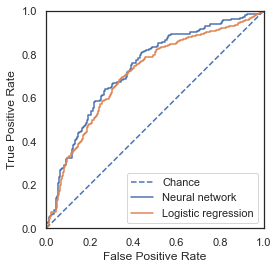

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [209]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

beingsaved = plt.figure()
#fpr2, tpr2, threshold = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
# calculate roc curves
#ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
# plot the roc curve for the model
ax = pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Chance')
pyplot.plot(fnn2, tnn2, color='b', label = 'Neural network')
pyplot.plot(flg, flg2,  label='Logistic regression')
plt.legend(loc = 'lower right')
#pyplot.plot(fpr2, tpr2, marker='.', label='Random Forest')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
beingsaved.savefig('roc.eps', format='eps', dpi=300,  transparent=True)